In [10]:
import pandas as pd
from matplotlib import pyplot as plt

In [11]:
# Post formatting
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['savefig.facecolor'] = 'white'

Understanding and respecting data privacy is an increasingly important responsibility, which all data controllers and processors must take when handling personal information. But what do we mean when we talk about data privacy? And how can we go about measuring something as abstract and conceptual as anonymity?

In this article, we investigate a recently proposed statistical metric used to measure the privacy of trajectory datasets. We consider the capabilities and limitations of the method and illustrate the process of measuring privacy using a publicly available dataset of mobile spatio-temporal data.

## What is Privacy?

Before we go about measuring it, it's a good idea to have a firm understanding of exactly what we mean when we talk about privacy in a data scientific context. We usually consider privacy to be the extent to which an individual is able to limit or control access to their personal information. However, data privacy is a little bit more general; it refers to the protections or safeguards against the potential misuse of an individual's data with reference to their rights and consent.

### Privacy vs Security

Whereas data security places its focus on protecting an individual's data by implementing techniques such as authentication, encryption and access control, data privacy is more concerned with mitigating against the risk that the data you provide to others, either knowingly or unknowingly, is used for nefarious purposes. This risk can manifest anywhere from tracking your location in real-time to showing you targeted adverts without your consent; both can represent a breach of your individual privacy.

Privacy is not necessarily the same as security; in fact, it is often the case that people are asked to decrease their standards for individual privacy to safeguard a society's safety and security in the face of crime and terrorism. Similarly, privacy campaigners and activists argue that a decrease in security is an acceptable risk to maintain every individual's right to privacy and civil liberties.

### Hiding in Plain Sight

Similarly to how data security experts have access to a wide range of tools such as encryption and authentication, data privacy experts have their own arsenal of techniques on hand to help mitigate privacy risks. One of the most common techniques used to enhance data privacy is anonymisation, a process by which an individual's data can be published in a dataset, without revealing their identity or other sensitive information.

Let's consider a data schema that might reasonably be collated by the MyWarwick application. It contains personal information about each student (their name, date of birth and university ID), the location of the student collected through the application (remember, MyWarwick requests location permissions to improve its campus map) and each student's mark for a recent Tabula assignment. 

|Full Name|Date of Birth|University ID|Location|Mark|
|:--:|:--:|:--:|:--:|:--:|
|Hugh Heath|1998-02-21|`u1602937`|`52.379925, -1.557104`|54%|
|Nyla Idris|1998-06-17|`u1672635`|`52.282188, -1.531144`|95%|
|Rosa Coates|1998-03-15|`u1646945`|`52.384243, -1.559346`|68%|
|$\vdots$|$\vdots$|$\vdots$|$\vdots$|$\vdots$|

MyWarwick wants to outsource this information to a fictional third party data processor, Warwick Analytica, with the brief of identifying whether there is a correlation between student location and the mark they achieved in the assignment. However, before they can release the data, they are required to anonymise it. 

The simplest form of anonymisation is the redaction of personally identifiable information—data which is very likely, if not guaranteed, to be unique to a single individual. Examples might include your full name and date of birth, your National Insurance number or university ID. The inclusion of personally identifiable information in a dataset significantly increases the likelihood and severity of a potential privacy attack, so it is often completely removed (data sanitisation) or replaced with an artificial identifying value (data pseudonymisation) instead. 

|Pseudonym|Location|**Mark**|
|:--:|:--:|:--:|
|`1d36cc`|`52.379925, -1.557104`|54%|
|`e1f999`|`52.282188, -1.531144`|95%|
|`c60764`|`52.384243, -1.559346`|68%|
|$\vdots$|$\vdots$|$\vdots$|

This way, it's a lot harder for an observer to learn sensitive information about a target individual from the data—but it's not impossible.

### Background Knowledge

Although this process successfully guarantees anonymity in isolation (i.e. when we have no extra information outside of the data), with additional background knowledge, it's still possible to perform a privacy attack on users in the dataset.

Let's say you know that your friend Hugh, who completed the assignment, is currently at home in Jack Martin 2 (`52.379925, -1.557104`). By linking this information with MyWarwick's 'anonymised' data, we can isolate Hugh's mark of 54% as well as his pseudonym (which could be used to identify him in other datasets)—all without his consent. 

Similarly, if Nyla was the student in the dataset who achieved a mark of 95% and later posted about her success on a public LinkedIn or Instagram page, this data could still be used to isolate her current location (`52.282188, -1.531144`—most likely a well deserved celebratory coffee at Procaffeinate) and her pseudonym. 

These example privacy breaches are extreme and arguably unlikely; however, it demonstrates that anonymised data rarely exists in isolation. Background knowledge for a dataset will always exist in some form, and each piece of background information constitutes a privacy risk to the anonymised dataset.

For that reason, in order to limit the effectiveness of reidentification attacks, we often employ more rigorous methods of guaranteeing the privacy and anonymity of data than just data sanitisation or pseudonymisation. 

## How is Privacy Measured?

Privacy is a difficult quality to measure for a dataset, principally because it's difficult to formally define. Unlike other statistical properties of data, there is no universally agreed formula or procedure to measure privacy. As a result, it's difficult for data collectors to communicate the extent to which user data is anonymised or handled in a privacy-preserving manner. 

Before we can explore a recently proposed metric used to measure the risk of reidentification in a dataset, we need to make a few tweaks to a well-known children's board game...

### Guess Who?

In the popular board game _[Guess Who?](https://en.wikipedia.org/wiki/Guess_Who%3F)_, players take turns requesting and revealing information about a face on their respective, identical boards. Each player selects, or is dealt at random, an identity relating to a face on the board; to win, they must deduce their opponent's identity before their opponent can do the same. 

Each turn, the requester asks the revealer to disclose a feature about their selected face, to which the revealer responds honestly. From this information, the requester may be able to reduce their pool of potential secret identities the revealer may have adopted. The roles of requester and revealer then alternate until a player has successfully managed to isolate a single face belonging to their opponent (or is confident enough to make a guess at random), at which point the game ends. 

Although the game works perfectly well with its original ruleset, for this data privacy scenario we're going to make a few tweaks to make the game more interesting from a statistical perspective:

 - The roles of requester and revealer are fixed, and only the revealer has a secret face and identity.
 - The revealer's face is selected at random with a uniform probability distribution.
 - The requester cannot guess at random. They must completely isolate a single face to win.
 - The number of questions the requester can ask is limited by a number $p > 0$. The requester wins if they are able to deduce the revealer's face and identity within this limit; otherwise, the revealer wins.
 - The requester is not restricted to yes/no questions, but rather uses questions that completely identify a feature, such as, "What eye colour does your face have?".
 
Now that we've defined the rules, we can do what data scientists do best: analyse the game so that we can win more often!

### Running the Numbers

The difficulty of the game from the requester's perspective is effectively determined by the number of questions available, $p$, negotiated by the players before the start of the game. Therefore, we want to be able to calculate the probability of us winning (as the requester) with respect to a value of $p$:

$$P(\text{Win}\ |\ p)$$

We can start by breaking our calculation down into a smaller subproblem: given an arbitrary face, what is the probability of winning with $p$ questions if this is the correct face? To calculate this probability, we need to consider the features of the face that we could confirm through a question to the revealer and the number of other faces on the board that share those same features. 

|Identity|Hair Colour|Eye Colour|Has Hat|
|:--:|:--:|:--:|:--:|
|Alice|Black|Green|False|
|Bob|Brown|Blue|False|
|Charlie|Black|Brown|True|
|$\vdots$|$\vdots$|$\vdots$|$\vdots$|

For example, let's say we select Alice as our arbitrary face and we only have one question that we can ask ($p = 1$). Alice has black hair, green eyes and isn't wearing a hat. Given that we can only confirm one of these features, we need to consider the number of faces on the board that match with Alice's feature:

|Feature|Alice|Number of matching faces|
|:--:|:--:|:--:|
|Hair Colour|Black|4|
|Eye Colour|Green|2|
|Has Hat|False|10|

Unfortunately, this information suggests that it would be impossible to win if Alice is the secret face. Even if we asked about her most distinguishing feature, her eye colour, we would still be left with one other matching face and would lose the game. Therefore, our chance of winning is $0$ under these parameters.

$$P(\text{Win}\ |\ p = 1,\ \text{Secret Face is Alice}) = 0$$

However, if we're allowed two questions instead ($p = 2$), the game changes completely. Now we can ask about any two of Alice's features, which we can take from the possible subsets of features of size $2$.

|Subset of features|Alice|Number of matching faces|
|:--:|:--:|:--:|
|{Hair Colour, Eye Colour}|{Black, Green}|1|
|{Hair Colour, Has Hat}|{Black, False}|3|
|{Eye Colour, Has Hat}|{Green, False}|1|

This information suggests that our chances of winning with $p = 2$ are a lot higher than for $p = 1$, because Alice is the only face remaining on the board if we filter faces by her hair colour and eye colour or eye colour and the presence of a hat, irrespective of order. Assuming that we choose our features to reveal at random from a uniform distribution, we can calculate our chance of winning for $p = 2$ as $\frac{2}{3}$ from the table above, if Alice is the secret face. Those odds are pretty good and are certainly a lot better than our $0\%$ chance of winning for $p = 1$.

$$P(\text{Win}\ |\ p = 2,\ \text{Secret Face is Alice}) = \frac{2}{3}$$

Clearly, we can't take this probability to be our overall chance of winning because it relies on the assumption that Alice is the revealer's secret face. However, we can use the fact that the secret face is chosen randomly using a uniform distribution to find an average chance of winning across all possible faces.

$$P(\text{Win}\ |\ p) = \frac{\sum_{f \in \text{Faces}} P(\text{Win}\ |\ p,\ \text{Secret Face is }f)}{\text{Number of Faces}}$$

From this, we can reasonably estimate our chance of winning a modified game of _Guess Who?_ given a value of $p$. But what happens if we abstract this concept further? Can we apply this approach of quantifying the reidentifiability of faces in a board game to more general data sets? The answer is yes, and it's already being explored through a privacy measure called _unicity_.

### Understanding Unicity

Unicity is a privacy metric that measures the risk that individuals in a dataset will be reidentified following the disclosure of $p$ data points. In other words, it quantifies the risk of reidentification for users in a dataset, assuming that an adversary (the person who wants to breach an individual's privacy) already has access to $p$ data points of background knowledge. It was first defined in 2013 as a method of quantifying the reidentifiability of individuals based on mobile phone location data and uses a similar approach to our previous analysis of the modified _Guess Who?_ ruleset. 

Consider a dataset $D$ containing the location history of mobile phone users over time. This data, when grouped by user, forms a number of _trajectories_ across a time interval. That is to say, each user has a single trajectory in the dataset, composed of (likely) numerous location-time pairs. By choosing a selection of these pairs, we can form a _subtrajectory_. We can formalise this as so:

1. Given one such trajectory $T$, we isolate $I_p \subseteq T$, a subtrajectory of $p$ spatio-temporal points randomly selected from $T$. 

It will often be the case that trajectories overlap (i.e. two users are in the same place at the same time). Although it is highly unlikely that two trajectories are complete duplicate, it may be the case that a subtrajectory is compatible with multiple trajectories. That is to say, there is more than one trajectory that contains all spacio-temporal pairs from the subtrajectory. We can again formalise this notion:

2. We compute $S(I_p) = \{T\ |\ T \in D,\ I_p \in T\}$, which is defined as the set of all trajectories in the dataset which are compatible with $I_p$. 

Finally, we are particularly interested in subtrajectories that have only one compatible trajectory. That way, if an adversary knew that a certain user followed that subtrajectory, they would have uniquely idenitified that user in the dataset and could take advantage of all corresponding trajectory data—the exact outcome we would like to avoid. Formally, we have:

3. The subtrajectory $I_p$ is uniquely characterised if $|S(I_p)| = 1$, meaning that $T$ is uniquely identifiable if all points in $I_p$ are revealed. 

Unicity  ($\varepsilon_p$) is calculated by finding the proportion of uniquely characterised subtrajectories out of all possible subtrajectories across all trajectories in a dataset, given a value of $p$ points to reveal. The unicity of a dataset therefore gives us the probability that a randomly chosen trajectory (or user) will be reidentified from a dataset given that $p$ of their data points are known.

Consider this with respect to our analysis of the modified Guess Who ruleset: 

1. Given a face, we took a subset of $p$ features from the face to represent the features that would be disclosed by the revealer through our questions. 
2. We then found the number of faces on the board with a matching subset of features, or alternatively, we removed all the faces on the board which didn't match the subset of features.  
3. If there was only one matching face, this represented a winning result as we were successfully able to reidentify the face given a subset of its features. 

We then computed the probability of winning for this face using all possible subsets of features of size $p$ and subsequently averaged this value across all faces to get an overall probability of winning given $p$ questions.

The resemblance should be fairly clear. Comparing unicity to the probability of winning our modified version of _Guess Who?_ offers a clear visualisation of the privacy metric; but, to really see the utility of such a technique, we need to apply it to a real-world dataset. 

## Case Study: 24 Hours in Shanghai

On June 1st 2014, 2979 ordinary people woke up to a warm Sunday morning in the Chinese city of Shanghai. These individuals, linked together only by their choice of mobile service provider, went about their daily lives in the heaving metropolis of over 24 million people, tapping, chatting and swiping on their phones as they went. 

What these individuals may not have realised was that their mobile service provider, Shanghai Telecom, was following their movements across the city through their mobile phones, by recording the closest base station to the device each time a user accessed the internet through mobile data. This information was later published publicly for use in computer science research, and although personally identifiable information was removed from the dataset before publication, we can use unicity to explore how the data still carries a privacy risk to the 2979 individuals who used their Shanghai Telecom phones on that date.

### Preparing the Data

The full Shanghai Telecom dataset consists of over 7.2 million records of mobile internet accesses across the city over a period of 6 months. Data was collected from 9481 mobile devices accessing 3233 different base stations around the city. Each record contains a pseudonym identifier for a particular user, the start and end times for which their mobile data was in use and the geographic location of the base station used to provide network access to the device.

|Start Time|End Time|Location|User ID|
|:--:|:--:|:--:|:--:|
|01/06/2014 10:22|01/06/2014 11:09|`31.237872/121.470259`|`edbc54...`|
|01/06/2014 07:00|01/06/2014 08:49|`31.237872/121.470259`|`f8206a...`|
|$\vdots$|$\vdots$|$\vdots$|$\vdots$|

Because the complete 6-month dataset is so large, it would be infeasible to calculate unicity across the full time interval. Instead, we can limit our dataset to a single day (01/06/2014) in the 6-month period and use this as a representative sample to estimate the unicity for the full time period.

Furthermore, we want to change the way that the dataset considers the time at each data point. Having time represented as a range between a start point and an end point is helpful if we want to investigate the duration of mobile data usage, but for our purposes, it's more useful to have data recorded at a single point in time as opposed to a time interval, so that it becomes a trajectory of locations over time. To achieve this, we take the midpoint of the start and end time and round it to a suitable time interval of 60 minutes. This has the added positive effect of coalescing groups of high frequency, low duration records into single data points. 

Following the data cleaning procedure, the dataset now contains 20851 records, representing the movements of 2979 users on 01/06/2014. 

|Location|User ID|Time|
|:--:|:--:|:--:|
|`31.237872/121.470259`|`edbc54...`|2014-06-01 11:00:00
|`31.237872/121.470259`|`f8206a...`|2014-06-01 08:00:00
|$\vdots$|$\vdots$|$\vdots$|

### Developing the Experiment

To perform analysis on our cleaned dataset, I developed a Python module called `unicity` to facilitate the calculation of unicity in arbitrary datasets. Much of the module contains helper functions to facilitate the experiment interface and the data cleaning procedure; the core functionality of unicity calculations is provided by the `unicity` function in `unicity/stats.py`. This function facilitates the calculation of unicity for any arbitrary dataset with a user identifier column. I encourage you to experiment using it yourselves and test it out on your own datasets.

We can use the `unicity` module to compute the unicity of our cleaned dataset at different values of $p$. From this, we can demonstrate how the number of data points revealed through background knowledge affects the risk of reidentification in a dataset. 

### Risk of Reidentification

Calculating unicity values for the dataset with $p$ values between 1 and 10 gave us the following results:

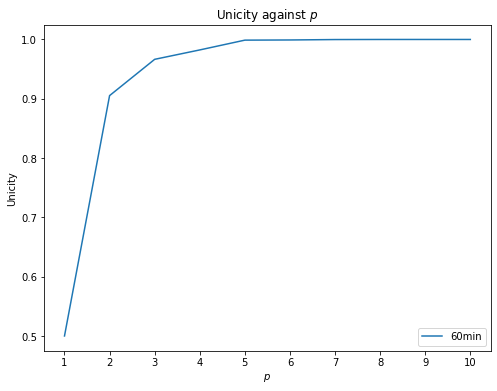

In [12]:
data = pd.read_csv("results/2014-06-01.csv")
data = data[data["resolution"] == "60min"]
plt.figure(figsize=(8, 6))
a = plt.axes()
a.set_xlabel("$p$")
a.set_ylabel("Unicity")
a.set_title("Unicity against $p$")
for res in set(data["resolution"]):
    d = data[data["resolution"] == res]
    plt.plot(d["p"], d["unicity"], label="60min")
a.legend(loc='lower right')
a.set_xticks(range(1, 11))
plt.show()

As we would expect, the risk of reidentification increases with the amount of background knowledge released. However, you may be surprised how little information is required to reidentify individuals in the dataset with high accuracy: for $p = 1$, unicity is 0.50024. Therefore, the probability of successful reidentification is just over 50%. However, just by adding one more piece of spatio-temporal data at $p = 2$, we increase this risk to just over 90%. At $p = 3$, this increases to over 96%. For $p \geq 5$, the probability of successfully reidentifying an individual is over 99%.

In other words, if you knew the location of one of the 2979 users at any five points in time on 01/06/2014, you would be able to reidentify them in the dataset with a probability of over 99%. This would also reveal their pseudonym identifier to you, allowing you to track their movements across the city for the entire 6 month time period included in the dataset. 

However, these results also highlight an important limitation of unicity. Shanghai is a city with over 24 million inhabitants, and yet, our findings appear to suggest that just 5 spatio-temporal points are sufficient to reidentify any inhabitant with over 99% accuracy. Is this really the case?

The answer is no, because our data only takes into consideration the movements of 2979 out of the 24 million inhabitants of Shanghai. Therefore, any probabilities relating to the reidentification of an individual which are derived from unicity are limited by the constraint that the individual is known to be in the dataset. Otherwise, we don't have enough information to derive the probability of reidentification for the wider population. 

This is the primary limitation of unicity and similar privacy metrics: because it only gives us the risk of reidentification for individuals within a dataset, we can't extrapolate this information to find the risk of reidentification for a wider population without additional data. This limits the applicability of unicity to real-world contexts because it's very rare to have enough data to represent an entire population. 

However, this limitation doesn't stop unicity from excelling at one of its best applications: comparing the efficacy of different methods of increasing privacy in a dataset.

### Zoom and Enhance

The granularity of information in a dataset has a substantial impact on the privacy of individuals in the dataset. For example, tracking your precise location every second provides almost no privacy, whereas tracking your location to the nearest postcode every hour provides offers much more. This is because the data becomes more generalised as its resolution decreases; in other words, because there are several people passing through the same postcode every hour, the individual risk to privacy is reduced. 

Our dataset carries spatio-temporal information about users, so we can adjust the spatial and temporal resolution of our data and measure the effect this has on privacy using unicity. However, because the dataset already uses a discrete set of points to represent location data (the locations of base stations in Shanghai), it is more difficult to change our spatial resolution. We can, however, easily modify the temporal resolution of our data by changing the time interval used when rounding time midpoints during the data cleaning process.

Comparing unicity over $p$ with temporal resolutions of 60 minutes, 120 minutes, 180 minutes and 240 minutes, we find the following results:

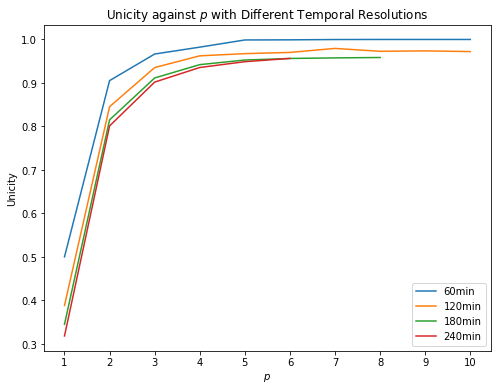

In [13]:
data = pd.read_csv("results/2014-06-01.csv")
plt.figure(figsize=(8, 6))
a = plt.axes()
a.set_xlabel("$p$")
a.set_ylabel("Unicity")
a.set_title("Unicity against $p$ with Different Temporal Resolutions")
for res in data["resolution"].unique():
    d = data[data["resolution"] == res]
    plt.plot(d["p"], d["unicity"], label=res)
a.legend(loc='lower right')
a.set_xticks(range(1, 11))
plt.show()

We can draw two important conclusions from these results: 

 - Unicity, and by extension, the risk of reidentification in the dataset decreases with temporal resolution.
 - However, for large $p$, it is possible to accurately (>90%) reidentify users regardless of temporal resolution.

This suggests that, although decreasing data granularity increases privacy and anonymity in a dataset, individuals are still at risk of reidentification when large amounts of background information are known. 

## Conclusion

This article has given an insight into the world of data privacy and demonstrated just one method which data scientists might use to measure privacy risks in an anonymised dataset. We've used a metric for measuring the risk of reidentification in a dataset, unicity, to demonstrate how background knowledge can allow us to reidentify individuals based on their location data with high accuracy. We've also shown that, to increase the privacy of users in a dataset, you can lower the temporal resolution of your data to make it appear more generalised.

What this article has intentionally not addressed is why you should care about privacy; an area often seen as the more political or sociological aspect of data privacy. Regardless of your opinions towards the importance of individual privacy, this article has demonstrated how easy it is for the illusion of privacy to be shattered by seemingly insignificant pieces of background information. Furthermore, understanding the ways in which privacy can be compromised is an important step in the direction of learning how to responsibly collect, clean, store and process information from individuals who are protected by data protection law; a skill necessary for all data scientists. Hopefully, that's an idea we can all get behind.

*The [dataset](http://sguangwang.com/TelecomDataset.html) used in this article is publicly available and was provided by academics from the Beijing University of Posts and Telecommunications. A full appendix of experimental results collected from this project is available on [GitHub](https://github.com/AlistairRobinson/Unicity/blob/master/results/2014-06-01.csv)*.